In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from hnn_core import jones_2009_model, simulate_dipole, Network
from hnn_core.network import _create_cell_coords
from hnn_core.cells_default import pyramidal, basket
from hnn_core.viz import plot_dipole

## Initializing the Network

First, we instantiate the standard Jones 2009 model. This model serves as the baseline for our exploration.

In [2]:
net = jones_2009_model()
print(f"Network created with {len(net.cell_types)} cell types")
print(f"Cell types: {list(net.cell_types.keys())}")

Network created with 4 cell types
Cell types: ['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']


In [3]:
type(net.cell_types) # cell types are returned as a dictionary now for us to see

dict

In [4]:
# showcasing the strucutre inside 
for cell_type_name, cell_type_data in net.cell_types.items():
    print(f"\n{cell_type_name}:")
    metadata = cell_type_data["cell_metadata"]
    for key, value in metadata.items():
        print(f"  {key}: {value}")


L2_basket:
  morpho_type: basket
  electro_type: inhibitory
  layer: 2
  measure_dipole: False
  reference: https://doi.org/10.7554/eLife.51214

L2_pyramidal:
  morpho_type: pyramidal
  electro_type: excitatory
  layer: 2
  measure_dipole: True
  reference: https://doi.org/10.7554/eLife.51214

L5_basket:
  morpho_type: basket
  electro_type: inhibitory
  layer: 5
  measure_dipole: False
  reference: https://doi.org/10.7554/eLife.51214

L5_pyramidal:
  morpho_type: pyramidal
  electro_type: excitatory
  layer: 5
  measure_dipole: True
  reference: https://doi.org/10.7554/eLife.51214


## Querying Cell Types

The `net.cell_types` dictionary contains the metadata for each cell type. We can filter and query this information to find specific groups of cells based on their properties, such as layer, ephys, or morphology.

In [5]:
excitatory = net.filter_cell_types(electro_type='excitatory')
print(f"Excitatory cells: {excitatory}")

layer2_cells = net.filter_cell_types(layer='2')
print(f"Layer 2 cells: {layer2_cells}")

dipole_contributors = net.filter_cell_types(measure_dipole=True)
print(f"Dipole contributors: {dipole_contributors}")

Excitatory cells: ['L2_pyramidal', 'L5_pyramidal']
Layer 2 cells: ['L2_basket', 'L2_pyramidal']
Dipole contributors: ['L2_pyramidal', 'L5_pyramidal']


## Inspecting Connection Weights

We can also use metadata to investigate the connectivity of the network. The existing `net.connectivity` list stores information about all connections, which we can inspect to understand the default weights and delays.

In [6]:
src_example = 'L2_pyramidal'
target_example = 'L2_pyramidal'

print(f"Example: {src_example} \u2192 {target_example} proximal connections")

for conn in net.connectivity:
    if (conn['src_type'] == src_example and 
        conn['target_type'] == target_example and 
        conn['loc'] == 'proximal'):
        
        weight = conn['nc_dict']['A_weight']
        gain = conn['nc_dict'].get('gain', 1.0)
        
        print(f"Receptor: {conn['receptor']}")
        print(f"  Base weight: {weight:.6f} \u03bcS")
        print(f"  Gain factor: {gain}")
        print(f"  Effective weight: {weight * gain:.6f} \u03bcS")
        print(f"  Delay: {conn['nc_dict']['A_delay']} ms")
        print(f"  Space constant: {conn['nc_dict']['lamtha']}")

Example: L2_pyramidal → L2_pyramidal proximal connections
Receptor: nmda
  Base weight: 0.000500 μS
  Gain factor: 1.0
  Effective weight: 0.000500 μS
  Delay: 1.0 ms
  Space constant: 3.0
Receptor: ampa
  Base weight: 0.000500 μS
  Gain factor: 1.0
  Effective weight: 0.000500 μS
  Delay: 1.0 ms
  Space constant: 3.0


### Identifying Dipole Contributors

The `measure_dipole` metadata field indicates whether a cell type's activity is included in the dipole calculation. This is something that would not be used in your Day to Day activity, but is relevant if you want to know more about the model you are working with!

In [7]:
#cells that contribute to the dipole
dipole_cells = net.filter_cell_types(measure_dipole=True)
non_dipole_cells = net.filter_cell_types(measure_dipole=False)

print("Cells contributing to dipole signal:")
for cell_type in dipole_cells:
    print(f"{cell_type}")

print("\nCells NOT contributing to dipole signal:")
for cell_type in non_dipole_cells:
    print(f"{cell_type}")

Cells contributing to dipole signal:
L2_pyramidal
L5_pyramidal

Cells NOT contributing to dipole signal:
L2_basket
L5_basket


### Visualizing Cell Morphologies

another usecase is that metadata can be used to organize and annotate visualizations

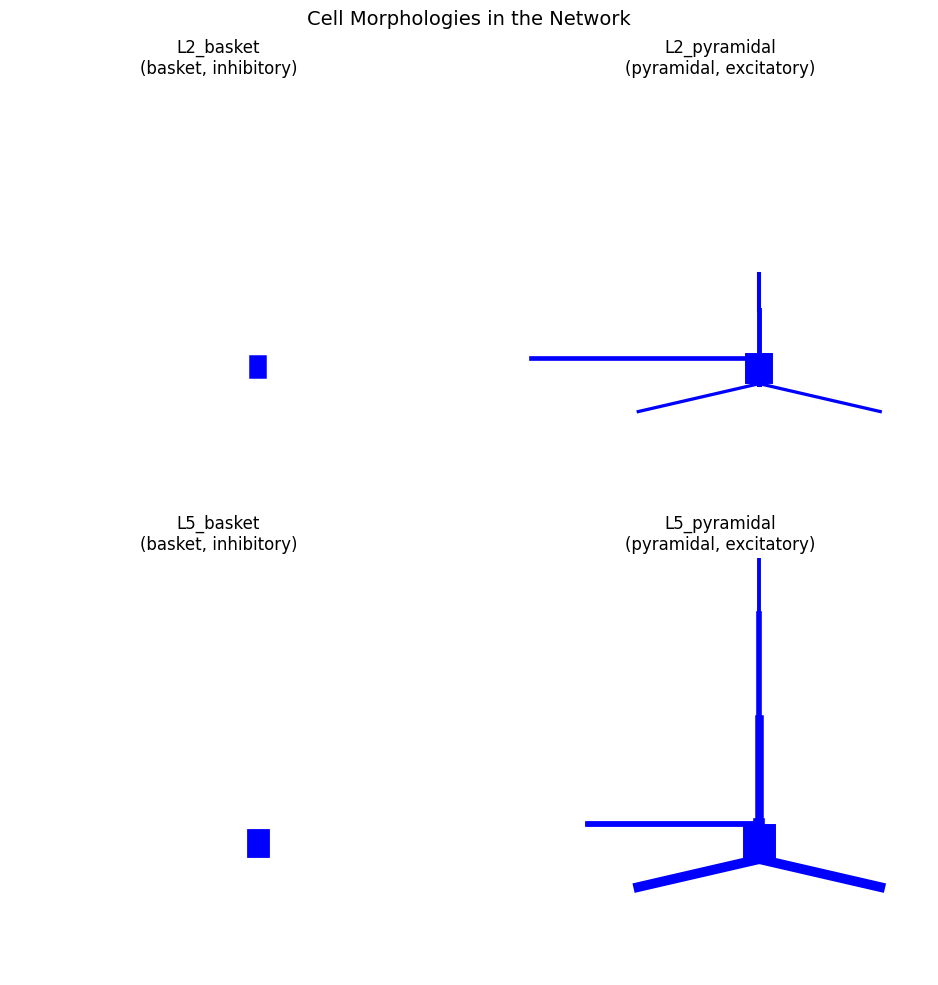

In [8]:
fig = plt.figure(figsize=(14, 10))

for idx, (cell_name, cell_data) in enumerate(net.cell_types.items()):
    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')  # Create 3D subplot
    cell_obj = cell_data["cell_object"]
    cell_obj.plot_morphology(ax=ax, show=False)
    #below we use annotations based on the metaData
    ax.set_title(f'{cell_name}\n({cell_data["cell_metadata"]["morpho_type"]}, '
                 f'{cell_data["cell_metadata"]["electro_type"]})')
    
plt.suptitle('Cell Morphologies in the Network', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

## Queries can be combined too!

combine multiple criteria to filter cell types. For example, we might want to find all excitatory cells in a specific layer.

In [9]:
# excitatory cells in layer 2
l2_excitatory = net.filter_cell_types(layer='2', electro_type='excitatory')
print(f"Layer 2 excitatory cells: {l2_excitatory}")

# properties of this filtered population
if l2_excitatory:
    cell_type = l2_excitatory[0]
    metadata = net.cell_types[cell_type]['cell_metadata']
    cell_count = len(net.pos_dict[cell_type])
    
    print(f"\nProperties of {cell_type}:")
    print(f"  Cell count: {cell_count}")
    print(f"  Morphology: {metadata['morpho_type']}")
    print(f"  Contributes to dipole: {metadata['measure_dipole']}")

Layer 2 excitatory cells: ['L2_pyramidal']

Properties of L2_pyramidal:
  Cell count: 100
  Morphology: pyramidal
  Contributes to dipole: True


### Inspecting Ion Channel Conductances

Another usecase allowing you to access the conductance parameters of ion channels across different cell types

In [10]:
# metadata to find a pyramidal cell, then examine its conductances
pyramidal_cells = net.filter_cell_types(morpho_type='pyramidal')
example_pyramidal = pyramidal_cells[0]

print(f"Conductances in {example_pyramidal}:")

cell_obj = net.cell_types[example_pyramidal]['cell_object']

# soma conductances as an example
if 'soma' in cell_obj.sections:
    soma_mechs = cell_obj.sections['soma'].mechs
    print("\nSoma ion channels:")
    for mech_name, mech_params in soma_mechs.items():
        conductances = {k: v for k, v in mech_params.items() 
                       if 'gbar' in k or 'gkbar' in k or 'gnabar' in k}
        if conductances:
            print(f"  {mech_name}: {conductances}")

# same for the dendritic section
if 'apical_tuft' in cell_obj.sections:
    tuft_mechs = cell_obj.sections['apical_tuft'].mechs
    if tuft_mechs:
        print("\nApical tuft ion channels:")
        for mech_name, mech_params in tuft_mechs.items():
            conductances = {k: v for k, v in mech_params.items() if 'gbar' in k}
            if conductances:
                print(f"  {mech_name}: {conductances}")

Conductances in L2_pyramidal:

Soma ion channels:
  km: {'gbar_km': 250.0}
  hh2: {'gkbar_hh2': 0.01, 'gnabar_hh2': 0.18}

Apical tuft ion channels:
  km: {'gbar_km': 250.0}


### Another usecase

what if you want to run a sim and see cell-type specific activity

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /home/zyban/opensource/hnn-core/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...


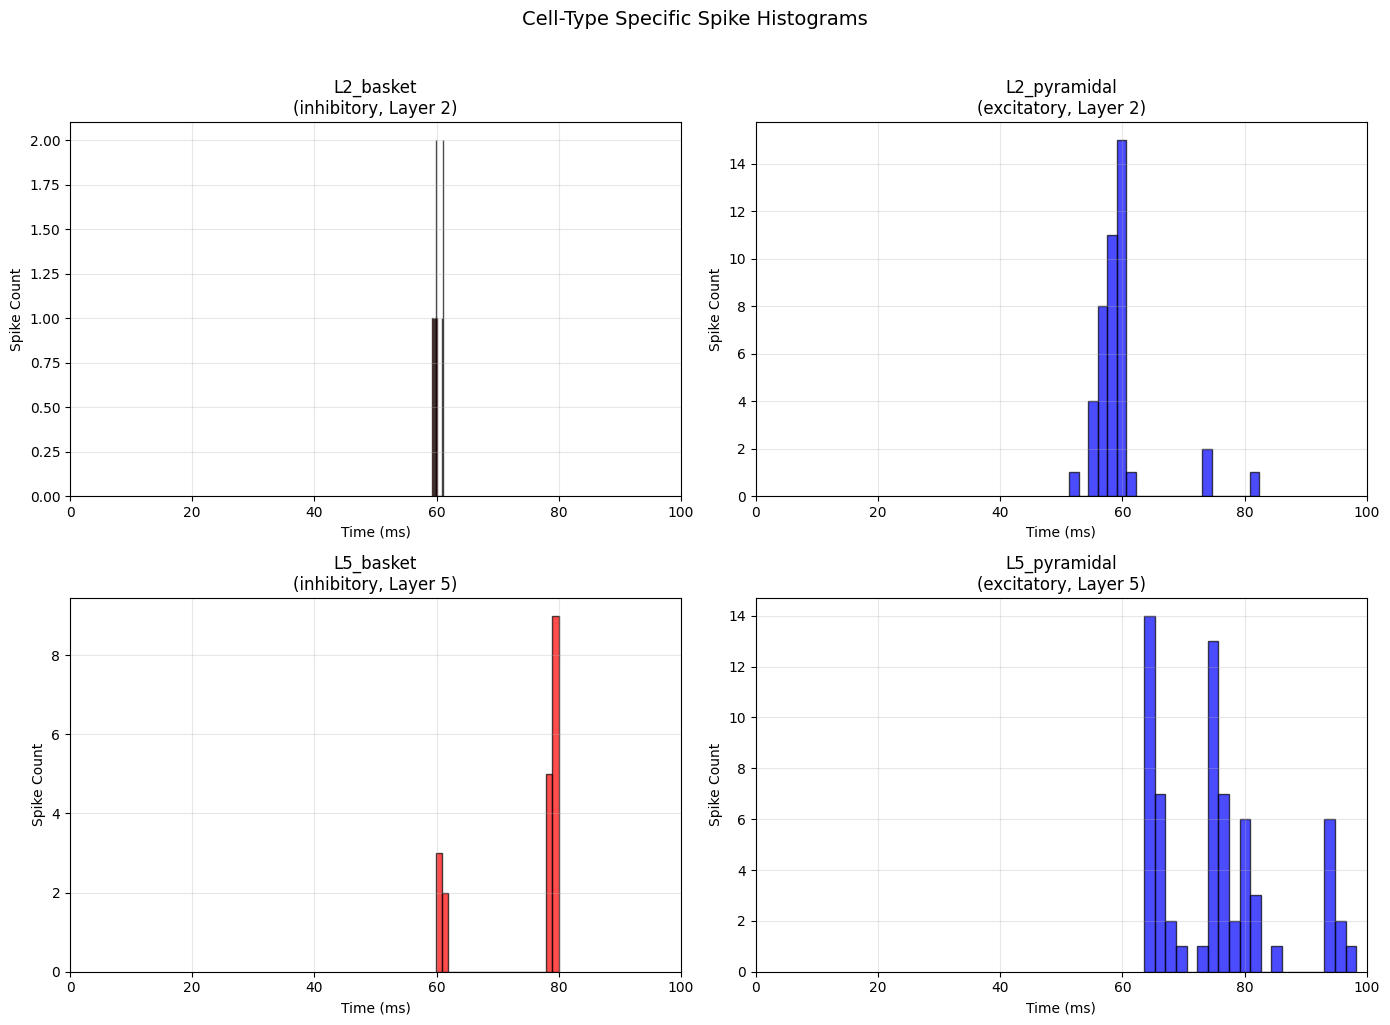

In [11]:
weights_ampa = {'L2_pyramidal': 0.001, 'L5_pyramidal': 0.001,
                'L2_basket': 0.0005, 'L5_basket': 0.0005}

net.add_evoked_drive(
    'test_drive', 
    mu=50.0, 
    sigma=5.0, 
    numspikes=1,
    weights_ampa=weights_ampa,
    location='proximal',
    event_seed=42
)

dpls = simulate_dipole(net, tstop=100., n_trials=1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

spike_times = net.cell_response.spike_times[0]
spike_gids = net.cell_response.spike_gids[0]
spike_types = net.cell_response.spike_types[0]

# histograms for each cell type
for idx, cell_type in enumerate(net.cell_types.keys()):
    ax = axes[idx // 2, idx % 2]
    
    cell_mask = np.array([st == cell_type for st in spike_types])
    cell_spike_times = np.array(spike_times)[cell_mask]
    
    # see if excitatory or inhibitory using metadata
    metadata = net.cell_types[cell_type]["cell_metadata"]
    color = 'blue' if metadata["electro_type"] == "excitatory" else 'red'
    
    if len(cell_spike_times) > 0:
        ax.hist(cell_spike_times, bins=20, color=color, alpha=0.7, edgecolor='black')
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Spike Count')
    ax.set_title(f'{cell_type}\n({metadata["electro_type"]}, Layer {metadata["layer"]})')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 100])

plt.suptitle('Cell-Type Specific Spike Histograms', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Tracking Weight Changes

We can also use metadata to verify changes in the network, such as modifications to synaptic weights
This ensures that our adjustments were applied correctly, in a clean manner

In [12]:
net_modified = net.copy()
net_modified.set_global_synaptic_gains(e_e=3.0)

# id the excitatory cells
excitatory = net.filter_cell_types(electro_type='excitatory')

src = 'L5_pyramidal' 
target = 'L5_pyramidal' 

print(f"Weight changes for {src} \u2192 {target}:")

# compare this connection
for idx, conn in enumerate(net.connectivity):
    if (conn['src_type'] == src and 
        conn['target_type'] == target and 
        conn['loc'] == 'proximal' and
        conn['receptor'] == 'nmda'):
        
        orig_weight = conn['nc_dict']['A_weight'] * conn['nc_dict'].get('gain', 1.0)
        mod_weight = (net_modified.connectivity[idx]['nc_dict']['A_weight'] * 
                     net_modified.connectivity[idx]['nc_dict'].get('gain', 1.0))
        
        print(f"NMDA receptor:")
        print(f"  Original weight: {orig_weight:.6f} \u03bcS")
        print(f"  Modified weight: {mod_weight:.6f} \u03bcS")
        print(f"  Change: {((mod_weight/orig_weight - 1) * 100):+.1f}%")
        break

Weight changes for L5_pyramidal → L5_pyramidal:
NMDA receptor:
  Original weight: 0.000500 μS
  Modified weight: 0.001500 μS
  Change: +200.0%


## how to make use of the create cell coords!

we had refactored _create_cell_coords() in network.py to return the new layer_dict structure

In [13]:
N_x, N_y = 5, 5  # 5x5 grid
z_L2 = 1000.0    # epth for Layer 2
z_L5 = 0.0       # Layer 5 at origin z

# use _create_cell_coords to generate a standard grid, or manually define our own positions
layer_dict = _create_cell_coords(
    n_pyr_x=N_x, 
    n_pyr_y=N_y, 
    z_coord=z_L2, 
    inplane_distance=20.0 
)

print("Layer Dictionary Keys:", layer_dict.keys())
print(f"Number of L5_bottom coordinates: {len(layer_dict['L5_bottom'])}")
print(f"Number of L2_bottom coordinates: {len(layer_dict['L2_bottom'])}")
print(f"\nExample L5_bottom coordinate: {layer_dict['L5_bottom'][0]}")
print(f"Example L2_bottom coordinate: {layer_dict['L2_bottom'][0]}")

Layer Dictionary Keys: dict_keys(['L5_bottom', 'L2_bottom', 'L5_mid', 'L2_mid', 'origin'])
Number of L5_bottom coordinates: 25
Number of L2_bottom coordinates: 25

Example L5_bottom coordinate: (np.float64(0.0), np.float64(0.0), 0)
Example L2_bottom coordinate: (np.float64(0.0), np.float64(0.0), 1000.0)


## Defining Custom Cell Types and Metadata

Finally, we can define our own custom cell types and attach arbitrary metadata to them. This is powerful for building novel networks or adding specific annotations for analysis.

In [14]:
# only for demo showing

In [15]:
custom_cell_types = {
    "L5_pyramidal": {
        "cell_object": pyramidal(cell_name="L5_pyramidal"),
        "cell_metadata": {
            "morpho_type": "pyramidal",
            "electro_type": "excitatory",
            "layer": "5",
            "measure_dipole": True,
            "neurotransmitter": "glutamate",  # see
            "role": "output_layer"            # see
        }
    },
    # trivial basket cell
    "L5_interneuron": {
        "cell_object": basket(cell_name="L5_basket"),
        "cell_metadata": {
            "morpho_type": "basket",
            "electro_type": "inhibitory",
            "layer": "5",
            "measure_dipole": False,
            "neurotransmitter": "gaba",       
            "role": "local_inhibition"       
        }
    }
}

custom_pos_dict = {
    "L5_pyramidal": layer_dict["L5_bottom"],  # bottom of L5
    "L5_interneuron": layer_dict["L5_mid"],   # middle of L5
}

print("Custom cell types defined:")
for name, data in custom_cell_types.items():
    print(f"  - {name}: {data['cell_metadata']}")

Custom cell types defined:
  - L5_pyramidal: {'morpho_type': 'pyramidal', 'electro_type': 'excitatory', 'layer': '5', 'measure_dipole': True, 'neurotransmitter': 'glutamate', 'role': 'output_layer'}
  - L5_interneuron: {'morpho_type': 'basket', 'electro_type': 'inhibitory', 'layer': '5', 'measure_dipole': False, 'neurotransmitter': 'gaba', 'role': 'local_inhibition'}


we pass our custom pos_dict and cell_types to the Network constructor

enabled by decoupling the parameter files from the internal object structure

In [16]:
# minimal
params = {"threshold": 0.0}

custom_net = Network(
    params=params,
    mesh_shape=(N_x, N_y),
    pos_dict=custom_pos_dict,
    cell_types=custom_cell_types
)

print(f"Custom Network Created with {len(custom_net.cell_types)} cell types")
print(f"Cell types: {list(custom_net.cell_types.keys())}")

for ct_name, ct_data in custom_net.cell_types.items():
    print(f"\n{ct_name}:")
    for key, val in ct_data['cell_metadata'].items():
        print(f"  {key}: {val}")

Custom Network Created with 2 cell types
Cell types: ['L5_pyramidal', 'L5_interneuron']

L5_pyramidal:
  morpho_type: pyramidal
  electro_type: excitatory
  layer: 5
  measure_dipole: True
  neurotransmitter: glutamate
  role: output_layer

L5_interneuron:
  morpho_type: basket
  electro_type: inhibitory
  layer: 5
  measure_dipole: False
  neurotransmitter: gaba
  role: local_inhibition


In [17]:
print("Roles of all cell types in the network:")
for cell_type, data in custom_net.cell_types.items():
    role = data['cell_metadata'].get('role', None)
    print(f"  - {cell_type}: {role}")

Roles of all cell types in the network:
  - L5_pyramidal: output_layer
  - L5_interneuron: local_inhibition


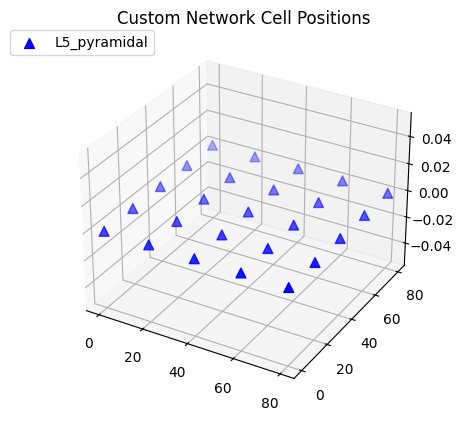

In [18]:
from hnn_core.viz import plot_cells

fig = plot_cells(custom_net, show=False)
plt.title("Custom Network Cell Positions")
plt.show()